# Implementation of YOLO (V3) - You Only Look Once 

Reading codes with little comments or help document could be a huge headache especially for most new-entry deep learning research engineers. This tutorial is designed to explain how to implement YOLO_V3, one of the state-of-art deep learning algorithms for object detection. In this work, the YOLO_V3 algorithm is trained from scratch using Pascal VOC dataset for demonstration purpose. Hopefully, after reading this tutorial, developers can build and train their own YOLO model using other datasets for various object detection tasks.  

YOLO_V3 network architecture is presented below. It makes use of only convolution layers and thus a fully convolutional network (FCN). It has skip connections with "bottleneck" layer (similer to ResNet), upsampling, no form of pooling to downsample but use convolutional layer with stride 2 (totally 5 downsampling events). This helps in preventing loss of low-level features often attributed to pooling.

YOLO_V3 makes prediction across 3 different scales with strides 32, 16 and 8 respectively (the stride is defined as image downsampling factor), which is a form of model ensembles to help YOLO_V3 better detect different scale objects. The first detection is made using feature maps with stride 32. The layers are then upsampled by 2 for second detection which is equivalent to stride 16. The same upsampling procedure is repeated, leading to the last detection is with stride 8. For example, if a default 416 x 416 x 3 image is imported. The output detection feature map sizes are 13 x 13 (output_layer 1), 26 x 26 (output_layer 2), 52 x 52 (output_layer 3) respectively.

<img src="imgs/ipy_pic/yolo.png"  width="600" style="float: left;">

# Interpreting the network output 

For the output detection layers, each cell can predict an object. Depth-wisely, the detection maps have B x (5 + C) entries, where B is the number of bounding boxes, C is the number of classes. YOLO v3 predicts 3 bounding boxes for every cell and thus B = 3. Each of the bounding boxes have 5 + C attributes, which describe the center coordinates, the dimensions, the objectness score and C class confidences. Pascal VOC dataset has 20 classes. Thus B x (5 + C) = 3 x (5 + 20) = 75. 

The detection will be made if the objectness score is higher than the threshhold. However only the cell of which the center of the ground truth box fails in its receptive field (as shown of the red cell in the below image) is expected to predict this lovely dog (marked yellow). Among the three bounding boxes in this cell, the one with highest IoU with ground truth box is responsible for detecting the object. This is the basic logic on how to train the YOLO which will be explained in detail in the "YOLO_V3_Training_Step_by_Step" script 

<img src="imgs/ipy_pic/yolo-5.png" width="300" style="float: left;">

# Transforming the output

The three output feature maps have different dimensions. It will make the prediction convenient by transforming the output and concatenate all three outputs. The "predict_transform" funcation (which will be shown later) takes the detecton feature map and turns it into a 2-D tensor, where each row of the tensor corresponds to attributes of a bounding box (5 + C). Specificlly the funcation accepts the output feature map as [batch_size, Bx(5+C), grid_size, grid_size]  Output will be: [batch_size, grid_size x grid_size x B, 5 + C]

<img src="imgs/ipy_pic/bbox.png" width="200" >

The "predict_transform" function also converts the network outputs to the predictions of input image. YOLO_v3 network doesn't predict the actual bounding box on original image because of the potential unstable gradients during training. Instead. it predicts the offset to center cooridinate and log-space transfroms to width and height to the pre-defined default bounding boxes called anchors. The pre-defined anchors dimensions for each detection feature output are: anchors_1 = [(116, 90), (156, 198), (373, 326)], anchors_2 = [(30, 61), (62, 45), (59, 119)], anchors_3 = [(10, 13), (16, 30), (33, 23)].  

The following formula describes how the network output is transformed to obtain bounding box predictions. bx, by, bw, bh are the x,y center co-ordinates, width and height of the prediction. tx, ty, tw, th are the network outputs. cx and cy are the top-left co-ordinates of the grid. pw and ph are anchors dimensions for the box.The below actions are needed to transform the network outputs to prediction on the input image:

1. Apply sigmoid activation for network output centre tx, centre ty, object confidence and classes


2. Add centre X offset (cx) and Y offset (cy) for center X and Y on the feature map to obtain bx and by. for example, the network output for center (0.4, 0.7) is transformed to (6.4, 6.7) if the top-left co-ordinates of the corresponding cell are (6, 6).


3. The above anchor attributes describe the dimensions of the input image, they have to be dividied by the stride of the detection feature map to obtain pw and ph. bw and bh are obtained based on the below equations.


4. The last thing is to resize the detections map to the size of the input image. The bounding box attributes here are sized by stride. For example, if the input image is 416 x 416, we multiply the attributes (bx, by, bw, bh) by 32, 16, 8 for output layer 1, layer 2 and lay 3 respectively. 


5. Finally all three output layers are concatenated together 

<img src="imgs/ipy_pic/e.png" width="200" style="float: left;">

# Output Processing 

For an image of size 416 x 416, YOLO will generate ((52 x 52) + (26 x 26) + 13 x 13)) x 3 = 10647 bounding boxes. The below actions will be applied to filer the bounding boxes and output the true detections.

1. The object confidence which passes through a sigmoid function represents the probability (0 to 1) to detect an object for that bounding box. The boxes with confidence score higher than the threshhold are reserved.


2. Stitching three output layers together leads to multiply valid bounding boxes detected surrounding the objects in the image. Non-maximum Suppression is applied to reduce the redundance. The bounding box with highest object confidence score is maintained and any remaining boxes with intersection over union value >= 0.4 (default) are discarded. 

 # Code 
 
 let's go to the exciting code part to implement Yolo_V3 model !

In [1]:
from __future__ import division
import time
import torch
from torch.autograd import Variable
import cv2
from utils.util import *
from Darknet_VOC import Darknet
import random
import argparse
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Build the YOLO V3 network

The VOLO_V3 network is implemented using Pytorch. Refer to the "Darknet_VOC.py" for details 

In [2]:
model = Darknet()
model.load_state_dict(torch.load('weights/Dartnet_VOC_Weights'))
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda()
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

### Preprocess the Image 

Theorially YOLO_V3 accepts any image sizes attributed to the FCN feature. However, in practice, YOLO_v3 perfers to accept fix sized, squared image. That help process the images easily in batches and conventiently implement the algorithm of dealing with the network output.

Let's first develop an image perprocessing function by padding the left out areas (keep the aspect ratio consistent) and resize the image. The image is converted to torch tensor and normalized to feed into the network. OpenCV loads the image with BGR color channel. The Pytorch input image is reordered as RGB. The same process is applided for training. 

In [3]:
def prep_image(img, inp_dim):

    h, w, _ = img.shape
    dim_diff = np.abs(h - w)
    # Upper (left) and lower (right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
    # Add padding
    pad_img = np.pad(img, pad, 'constant', constant_values=128)
    orig_im = pad_img
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im

The image size feeding into network is set as 416. Increasing the input resolution could increase the model accuracy but decrease the inference speed 

In [4]:
model.image_size = 416
inp_dim = int(model.image_size)

frame = cv2.imread('imgs/person.jpg')
img, orig_im = prep_image(frame, inp_dim)

if CUDA:
    img = img.cuda()
    
img.shape

torch.Size([1, 3, 416, 416])

### Check the final prediction and network output

Feeding image into network will generate 3 different output layers as demonstrated from the below code. "predict_transform" funcation has been embedding into "Darknet_VOC.py". Pascal VOC dataset has 20 classes. Thus the depth of output layer is 3x(5+20) = 75. 

In [5]:
Final_pre, outputlayer_3, outputlayer_2, outputlayer_1 = model(Variable(img), CUDA)
print('Final prediction shape is', Final_pre.shape)
print('layer_3 output shape is {}, layer_2 output shape is {}, layer_1 output shape is {}'
      .format(outputlayer_3.shape, outputlayer_2.shape, outputlayer_1.shape))

Final prediction shape is torch.Size([1, 10647, 25])
layer_3 output shape is torch.Size([1, 75, 52, 52]), layer_2 output shape is torch.Size([1, 75, 26, 26]), layer_1 output shape is torch.Size([1, 75, 13, 13])


### Build predict_transfrom function

let's have a close look on this function by taking the outputlayer_3 as an example. This funcation accepts the network output, input image size, corresponding anchor dimensions, number of classes. The final prediction is transfered step by step as explained before. 

In [6]:
def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
    
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction

In [7]:
prediction_layer_3 = predict_transform(outputlayer_3, inp_dim = 416, anchors = [(10, 13), (16, 30), (33, 23)], num_classes = 20, CUDA = True)
prediction_layer_3.shape

torch.Size([1, 8112, 25])

### Apply the NMS and objectness threshold 
The function "write_results" outputs a tensor of shape D x 8 after filering using NMS and objectness threshold. Here D is the true detections in all of images, each represented by a row. Each detections has 8 attributes, namely, index of the image in the batch to which the detection belongs to, 4 corner coordinates, objectness score, the score of class with maximum confidence, and the index of that class.

In [8]:
def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)

    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding 
       #NMS
    
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue
        
        if image_pred_.shape[0] == 0:
            continue           
  
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
        
        
        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

In [9]:
output = Final_pre
confidence = 0.5
nms_thesh = 0.4
num_classes = 20
output = write_results(output, confidence, num_classes, nms_conf=nms_thesh)
output.shape

torch.Size([3, 8])

### Load the VOC class name and pickled file

The output predicted class index from network needs to be converted as the name string. voc.names from data folder lists the corresponding names. load_classes function is defined to map the class index to name string.

Use data/pallete file to randomly choose colors to draw on the image

In [10]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

classes = load_classes("data/voc.names")
colors = pkl.load(open("data/pallete", "rb"))

Clip the bounding boxes in case the boundaries are outside the image edge. Convert the output values from resized image feeding into network to original image 

In [11]:
if isinstance(output, int) == False:
    output[:, 1:5] = torch.clamp(output[:, 1:5], 0.0, float(inp_dim)) / inp_dim
    output[:, [1, 3]] *= orig_im.shape[1]
    output[:, [2, 4]] *= orig_im.shape[0]

### Write Funcation to draw boxes on image

In [12]:
def write(x, img):

    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2, color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225, 255, 255], 1)

    return img

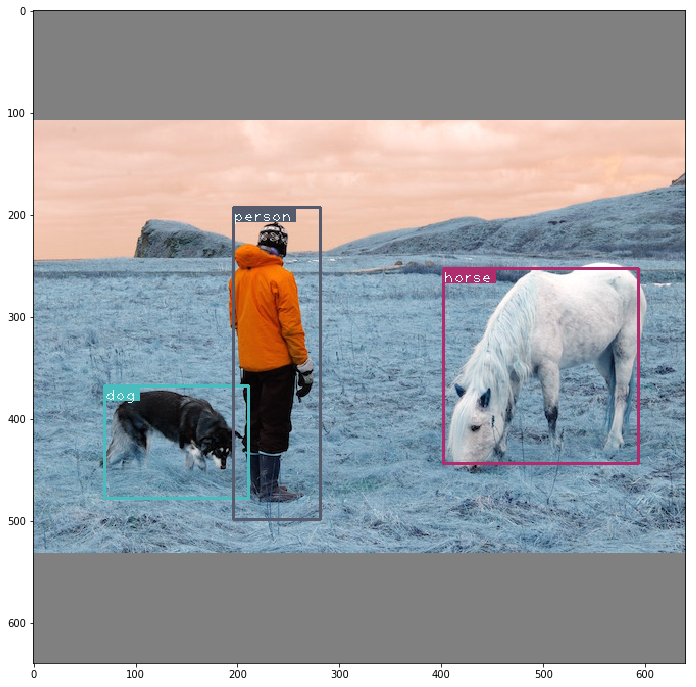

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

list(map(lambda x: write(x, orig_im), output))
orig_im = orig_im[:,:,::-1]
plt.imshow(orig_im, )